# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

Using: cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. Solving the Tennis Environment with DDPG

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
bSolved = False
num_episodes=1000
noise_episodes=500
num_agents = 2
agents = [Agent(state_size=state_size, action_size=action_size, random_seed=10) for _ in range(num_agents)]
scores_deque = deque(maxlen=100)
scores_all = []
scores_avg = []
best_score = 0
for i_episode in range(1, num_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
    states = env_info.vector_observations                        # get states from environment
    scores = np.zeros(num_agents)                                # initialize scores to zero
    actions = np.random.randn(num_agents, action_size)           # initialize actions to random
    t_step = 0
    while True:
        p = np.clip(1 - np.sqrt(i_episode/noise_episodes), 0, 1) # noise probability, decrease as agent converges
        for i in range(num_agents):
            actions[i] = agents[i].act(states.flatten(),         # select an action from policy
                               noise_prob = p,                   # add noise with probability p
                               noise_scale = 1,                  # scale noise
                               noise_type='ou',                  # type of noise (ou, uni)
                               noise_apply='add')                # how to apply noise (thres, fuse, add)

        env_info = env.step(actions)[brain_name]                 # send the actions to the environment
        next_states = env_info.vector_observations               # get next states
        rewards = env_info.rewards                               # get the rewards
        dones = env_info.local_done                              # see if episode has finished

        for i in range(num_agents): # agent step for each
            agents[i].step(states.flatten(), actions.flatten(), rewards, next_states.flatten(), dones, t_step, num_agents) 
            
        scores += rewards                                        # update the scores
        states = next_states                                     # roll over the states to next time step
        t_step += 1                                              # keep track of steps
        if np.any(dones):                                        # exit loop if episode finished
            break

    max_score = np.max(scores)
    scores_deque.append(max_score)
    scores_all.append(max_score)
    scores_avg.append(np.mean(scores_deque))
    print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque)), end="")
    if i_episode % 100 == 0:
        for i in range(0,num_agents):
            torch.save(agents[i].actor_local.state_dict(), 'checkpoints/actor' + str(i) + '_temp.pth')
            torch.save(agents[i].critic_local.state_dict(), 'checkpoints/critic' + str(i) + '_temp.pth')
        print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(scores_deque)))

    if max_score > best_score:
        for i in range(0,num_agents):
            torch.save(agents[i].actor_local.state_dict(), 'checkpoints/actor' + str(i) + '_best.pth')
            torch.save(agents[i].critic_local.state_dict(), 'checkpoints/critic' + str(i) + '_best.pth')
        best_score = max_score
            
    if np.mean(scores_deque) >= 0.5 and not bSolved:
        for i in range(0,num_agents):
            torch.save(agents[i].actor_local.state_dict(), 'checkpoints/actor' + str(i) + '_solved.pth')
            torch.save(agents[i].critic_local.state_dict(), 'checkpoints/critic' + str(i) + '_solved.pth')
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        bSolved = True

Episode 100	Average Score: 0.016	Max Score: 0.20
Episode 200	Average Score: 0.040	Max Score: 0.20
Episode 300	Average Score: 0.103	Max Score: 0.30
Episode 400	Average Score: 0.117	Max Score: 0.50
Episode 500	Average Score: 0.170	Max Score: 0.60
Episode 600	Average Score: 0.237	Max Score: 0.70
Episode 700	Average Score: 0.325	Max Score: 1.10
Episode 800	Average Score: 0.383	Max Score: 1.90
Episode 880	Average Score: 0.511	Max Score: 2.60
Environment solved in 880 episodes!	Average Score: 0.511
Episode 900	Average Score: 0.590	Max Score: 2.60
Episode 1000	Average Score: 0.912	Max Score: 2.70


Let's evaluate the trained agent and visualize its performance!

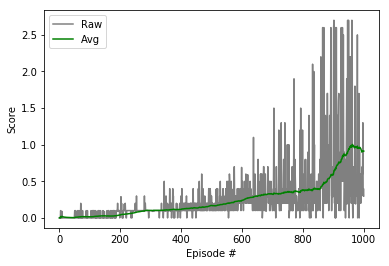

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all, color='gray', label='Raw')
plt.plot(np.arange(1, len(scores_all)+1), scores_avg, color='green', label='Avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [8]:
def evaluate(agents, n_episodes=10):
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get states from environment
        scores = np.zeros(num_agents)                          # initialize scores to zero
        actions = np.random.randn(num_agents, action_size)     # initialize actions to random
        while True:
            for i in range(num_agents):
                actions[i] = agents[i].act(states.flatten())   # select an action from policy
            env_info = env.step(actions)[brain_name]           # send the actions to the environment
            next_states = env_info.vector_observations         # get next states from environment
            rewards = env_info.rewards                         # get rewards from environment
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the scores
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('\rEpisode {} \tMax Score: {:.2f}'.format(i_episode, np.max(scores)))

In [9]:
for i in range(num_agents):
    agents[i].load('checkpoints/actor'+str(i)+'_best.pth', 'checkpoints/critic'+str(i)+'_best.pth')

In [10]:
evaluate(agents, n_episodes=10)

Episode 1 	Max Score: 0.20
Episode 2 	Max Score: 0.10
Episode 3 	Max Score: 2.60
Episode 4 	Max Score: 2.70
Episode 5 	Max Score: 2.70
Episode 6 	Max Score: 2.70
Episode 7 	Max Score: 2.60
Episode 8 	Max Score: 0.20
Episode 9 	Max Score: 0.30
Episode 10 	Max Score: 2.60


When finished, you can close the environment.

In [11]:
env.close()